In [1]:
! pip install tensorflow

In [8]:
! pip install -r requirements.txt

Obtaining file:///C:/Users/dhamn/Documents/GitHub/AA-Forecast (from -r requirements.txt (line 2))
  Using cached python_dotenv-1.0.0-py3-none-any.whl (19 kB)
  Using cached pycodestyle-2.7.0-py2.py3-none-any.whl (41 kB)
  Using cached pyflakes-2.3.1-py2.py3-none-any.whl (68 kB)
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: pyflakes
    Found existing installation: pyflakes 2.2.0
    Uninstalling pyflakes-2.2.0:
      Successfully uninstalled pyflakes-2.2.0
  Attempting uninstall: pycodestyle
    Found existing installation: pycodestyle 2.6.0
    Uninstalling pycodestyle-2.6.0:
      Successfully uninstalled pycodestyle-2.6.0
  Attempting uninstall: docutils
    Found existing installation: docutils 0.17
    Uninstalling docutils-0.17:
      Successfully uninstalled docutils-0.17
  Running setup.py develop for src


In [8]:
import matplotlib.pylab as pylab
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import tqdm
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = 12, 8


In [14]:
# Grid search
# import talos

df = pd.read_csv('./dataset/tax-sales-hurricane.csv', index_col=0)
category = 'Hotel'
print(df.shape)
df.tail()
countyNames = df["region"].unique()
countySplit = int(len(countyNames)*.8)
trainCounties = countyNames[10:]
testCounties = countyNames[0:10]
print('Total counties for', category, "category :", len(countyNames))
print('Train counties for', category, "category :", len(trainCounties))
print('Test counties for', category, "category :", len(testCounties))

df
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(
    df[['hurricane', 'observed', 'residual'	, 'seasonal'	, 'trend']])
df[['hurricane', 'observed', 'residual'	, 'seasonal'	, 'trend']] = scaler.transform(
    df[['hurricane', 'observed', 'residual'	, 'seasonal'	, 'trend']])
df

testCounties = ['Lee', 'Collier', 'Hardee', 'Sarasota', 'Orange', 'Palm Beach']
trainCounties = ['Alachua', 'Bay', 'Brevard', 'Broward', 'Citrus', 'Clay',
                 'DeSoto', 'Dixie', 'Duval', 'Escambia', 'Franklin',
                 'Gadsden', 'Gulf',  'Hendry', 'Hernando', 'Highlands',
                 'Hillsborough', 'IndianRiver', 'Jefferson', 'Lake',  'Leon',
                 'Levy', 'Manatee', 'Marion', 'Martin', 'Miami-Dade', 'Monroe',
                 'Nassau', 'Okaloosa',  'Osceola',
                 'Pinellas', 'Polk', 'Putnam', 'St. Johns', 'St. Lucie',
                 'Santa Rosa',  'Seminole', 'Sumter', 'Suwannee',
                 'Volusia', 'Wakulla', 'Walton']


(9936, 9)
Total counties for Hotel category : 48
Train counties for Hotel category : 38
Test counties for Hotel category : 10


In [15]:
### CREATE GENERATOR FOR LSTM WINDOWS AND LABELS ###
lossmetric = 'mean_absolute_error'
sequence_length = 8
dropae = 0.1


def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]


def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]


In [16]:
### CREATE TRAIN/TEST PRICE DATA ###
X_train_c, X_train_o = [], []
X_test_c, X_test_o = [], []
X_other_train_c, X_other_train_o = [], []
X_other_test_c, X_other_test_o = [], []

for county in df["region"].unique():

    for sequence in gen_sequence(df[(df["region"] == county) & (df["type"] == "Urban")],
                                 sequence_length, ['observed']):
        if county in trainCounties:
            X_train_c.append(sequence)

    for sequence in gen_sequence(df[(df["region"] == county) & (df["type"] == "Rural")],
                                 sequence_length, ['observed']):
        if county in trainCounties:
            X_train_o.append(sequence)

    for sequence in gen_sequence(df[(df["region"] == county) & (df["type"] == "Urban")],
                                 sequence_length, ['observed']):
        if county in testCounties:
            X_test_c.append(sequence)

    for sequence in gen_sequence(df[(df["region"] == county) & (df["type"] == "Rural")],
                                 sequence_length, ['observed']):
        if county in testCounties:
            X_test_o.append(sequence)


X_train_c, X_train_o = np.asarray(X_train_c), np.asarray(X_train_o)
X_test_c, X_test_o = np.asarray(X_test_c), np.asarray(X_test_o)
y_train_c, y_train_o = [], []
y_test_c, y_test_o = [], []
y_other_train_c, y_other_train_o = [], []
y_other_test_c, y_other_test_o = [], []

for county in df["region"].unique():

    for sequence in gen_labels(df[(df["region"] == county) & (df["type"] == "Urban")],
                               sequence_length, ['observed']):
        if county in trainCounties:
            y_train_c.append(sequence)

    for sequence in gen_labels(df[(df["region"] == county) & (df["type"] == "Rural")],
                               sequence_length, ['observed']):
        if county in trainCounties:
            y_train_o.append(sequence)

    for sequence in gen_labels(df[(df["region"] == county) & (df["type"] == "Urban")],
                               sequence_length, ['observed']):
        if county in testCounties:
            y_test_c.append(sequence)

    for sequence in gen_labels(df[(df["region"] == county) & (df["type"] == "Rural")],
                               sequence_length, ['observed']):
        if county in testCounties:
            y_test_o.append(sequence)


y_train_c, y_train_o = np.asarray(y_train_c), np.asarray(y_train_o)
y_test_c, y_test_o = np.asarray(y_test_c), np.asarray(y_test_o)
df['year'].unique()
splitTest = 197
customXLabel = []
for j in range(len(df['year'].unique())-1):
    j = j*12
    customXLabel.append(j)
customXLabel

[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192]

In [17]:
### CONCATENATE TRAIN/TEST DATA AND LABEL ###
XUrban = np.concatenate([X_train_c, X_test_c], axis=0)
XRural = np.concatenate([X_train_o, X_test_o], axis=0)

yUrban = np.concatenate([y_train_c, y_test_c], axis=0)
yRural = np.concatenate([y_train_o, y_test_o], axis=0)

In [18]:
print('Urban: ', XUrban.shape, ' - Rural ', XRural.shape)

Urban:  (6169, 8, 1)  - Rural  (2388, 8, 1)


In [19]:
### CREATE TRAIN/TEST EXTERNAL FEATURES ###
col = ['residual', "seasonal", 'trend', 'hurricane']

f_train_c, f_train_o = [], []
f_test_c, f_test_o = [], []
f_other_train_c, f_other_train_o = [], []
f_other_test_c, f_other_test_o = [], []


for county in df["region"].unique():

    for sequence in gen_sequence(df[(df["region"] == county) & (df["type"] == "Urban")],
                                 sequence_length, col):
        if county in trainCounties:
            f_train_c.append(sequence)

    for sequence in gen_sequence(df[(df["region"] == county) & (df["type"] == "Rural")],
                                 sequence_length, col):
        if county in trainCounties:
            f_train_o.append(sequence)

    for sequence in gen_sequence(df[(df["region"] == county) & (df["type"] == "Urban")],
                                 sequence_length, col):
        if county in testCounties:
            f_test_c.append(sequence)

    for sequence in gen_sequence(df[(df["region"] == county) & (df["type"] == "Rural")],
                                 sequence_length, col):
        if county in testCounties:
            f_test_o.append(sequence)


f_train_c, f_train_o = np.asarray(f_train_c), np.asarray(f_train_o)
f_test_c, f_test_o = np.asarray(f_test_c), np.asarray(f_test_o)

In [20]:
### CONCATENATE TRAIN/TEST EXTERNAL FEATURES ###
F = np.concatenate([f_train_c, f_train_o, f_test_c, f_test_o], axis=0)
FUrban = np.concatenate([f_train_c, f_test_c], axis=0)
FRural = np.concatenate([f_train_o, f_test_o], axis=0)

print(FUrban.shape, FRural.shape)


(6169, 8, 4) (2388, 8, 4)


In [21]:
"""# AutoEncoder Urban - Rural """

### SET SEED ###
# tf.random.set_seed(47)
os.environ['PYTHONHASHSEED'] = str(47)
np.random.seed(47)
random.seed(47)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(),
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


In [22]:
### LSTM AUTOENCODER ###
inputsUrbanAE = Input(shape=(sequence_length, 1))
encodedUrbanAE = GRU(128, return_sequences=True, dropout=dropae)(
    inputsUrbanAE, training=True)
decodedUrbanAE = GRU(32, return_sequences=True, dropout=dropae)(
    encodedUrbanAE, training=True)
outputUrbanAE = TimeDistributed(Dense(1))(decodedUrbanAE)

sequenceUrbanAE = Model(inputsUrbanAE, outputUrbanAE)
sequenceUrbanAE.compile(
    optimizer='adam', loss=lossmetric, metrics=[lossmetric])


In [23]:
### TRAIN AUTOENCODER ###
sequenceUrbanAE.fit(XUrban[:len(X_train_c)], XUrban[:len(X_train_c)],
                    # validation_data=(XUrban[len(X_train_c):], XUrban[len(X_train_c):]),
                    batch_size=128, epochs=30, verbose=2, shuffle=False)
os.environ['PYTHONHASHSEED'] = str(47)
np.random.seed(47)
random.seed(47)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(),
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

Epoch 1/30
41/41 - 12s - loss: 0.0339 - mean_absolute_error: 0.0339 - 12s/epoch - 304ms/step
Epoch 2/30
41/41 - 2s - loss: 0.0215 - mean_absolute_error: 0.0215 - 2s/epoch - 50ms/step
Epoch 3/30
41/41 - 2s - loss: 0.0155 - mean_absolute_error: 0.0155 - 2s/epoch - 51ms/step
Epoch 4/30
41/41 - 2s - loss: 0.0126 - mean_absolute_error: 0.0126 - 2s/epoch - 50ms/step
Epoch 5/30
41/41 - 2s - loss: 0.0113 - mean_absolute_error: 0.0113 - 2s/epoch - 49ms/step
Epoch 6/30
41/41 - 2s - loss: 0.0124 - mean_absolute_error: 0.0124 - 2s/epoch - 49ms/step
Epoch 7/30
41/41 - 2s - loss: 0.0119 - mean_absolute_error: 0.0119 - 2s/epoch - 50ms/step
Epoch 8/30
41/41 - 2s - loss: 0.0122 - mean_absolute_error: 0.0122 - 2s/epoch - 50ms/step
Epoch 9/30
41/41 - 2s - loss: 0.0118 - mean_absolute_error: 0.0118 - 2s/epoch - 51ms/step
Epoch 10/30
41/41 - 2s - loss: 0.0118 - mean_absolute_error: 0.0118 - 2s/epoch - 50ms/step
Epoch 11/30
41/41 - 2s - loss: 0.0114 - mean_absolute_error: 0.0114 - 2s/epoch - 51ms/step
Epoch

In [24]:
### LSTM AUTOENCODER ###
inputsRuralAE = Input(shape=(sequence_length, 1))
encodedRuralAE = GRU(128, return_sequences=True, dropout=dropae)(
    inputsRuralAE, training=True)
decodedRuralAE = GRU(32, return_sequences=True, dropout=dropae)(
    encodedRuralAE, training=True)
outputRuralAE = TimeDistributed(Dense(1))(decodedRuralAE)

sequenceRuralAE = Model(inputsRuralAE, outputRuralAE)
sequenceRuralAE.compile(
    optimizer='adam', loss=lossmetric, metrics=[lossmetric])


In [25]:
### TRAIN AUTOENCODER ###
sequenceRuralAE.fit(XRural[:len(X_train_o)], XRural[:len(X_train_o)],
                    batch_size=128, epochs=5, verbose=2, shuffle=False)

Epoch 1/5
18/18 - 11s - loss: 0.0513 - mean_absolute_error: 0.0513 - 11s/epoch - 631ms/step
Epoch 2/5
18/18 - 1s - loss: 0.0361 - mean_absolute_error: 0.0361 - 886ms/epoch - 49ms/step
Epoch 3/5
18/18 - 1s - loss: 0.0293 - mean_absolute_error: 0.0293 - 908ms/epoch - 50ms/step
Epoch 4/5
18/18 - 1s - loss: 0.0246 - mean_absolute_error: 0.0246 - 895ms/epoch - 50ms/step
Epoch 5/5
18/18 - 1s - loss: 0.0202 - mean_absolute_error: 0.0202 - 907ms/epoch - 50ms/step


In [64]:
"""# GRU after AutoEncoder Urban & Rural"""

os.environ['PYTHONHASHSEED'] = str(47)
np.random.seed(47)
random.seed(47)

dropOut = 0.3
epochs = 400
lstmcell1Urban = 256
lstmcell2Urban = 128
dense1Urban = 64

lstmcell1Rural = 128
lstmcell2Rural = 32
dense1Rural = 32


encoderUrban = Model(inputsUrbanAE, encodedUrbanAE)
XXUrban = encoderUrban.predict(XUrban)
XXFUrban = np.concatenate([XXUrban, FUrban], axis=2)
XXFUrban.shape
X_train1Urban, X_test1Urban = XXFUrban[:len(
    X_train_c)], XXFUrban[len(X_train_c):]
y_train1Urban, y_test1Urban = yUrban[:len(y_train_c)], yUrban[len(y_train_c):]
scaler1Urban = StandardScaler()
X_train1Urban = scaler1Urban.fit_transform(
    X_train1Urban.reshape(-1, XXFUrban.shape[-1])).reshape(-1, sequence_length, XXFUrban.shape[-1])
X_test1Urban = scaler1Urban.transform(
    X_test1Urban.reshape(-1, XXFUrban.shape[-1])).reshape(-1, sequence_length, XXFUrban.shape[-1])

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(),
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


193/193 [==============================] - 2s 7ms/step


In [65]:
### DEFINE FORECASTER ###
inputs1 = Input(shape=(X_train1Urban.shape[1], X_train1Urban.shape[2]))
lstm1 = GRU(lstmcell1Urban, return_sequences=True,
            dropout=dropOut)(inputs1, training=True)
lstm1 = GRU(lstmcell2Urban, return_sequences=False,
            dropout=dropOut)(lstm1, training=True)
dense1 = Dense(dense1Urban)(lstm1)
out1 = Dense(1)(dense1)

model1Urban = Model(inputs1, out1)
model1Urban.compile(loss=lossmetric, optimizer='adam', metrics=[lossmetric])


In [66]:
### FIT FORECASTER ###
historyUrban = model1Urban.fit(X_train1Urban[:4000], y_train1Urban[:4000], validation_data=(X_train1Urban[4000:], y_train1Urban[4000:]),
                               epochs=epochs, batch_size=128, verbose=2, shuffle=False)


Epoch 1/400
32/32 - 17s - loss: 0.1735 - mean_absolute_error: 0.1735 - val_loss: 0.0608 - val_mean_absolute_error: 0.0608 - 17s/epoch - 528ms/step
Epoch 2/400
32/32 - 5s - loss: 0.0394 - mean_absolute_error: 0.0394 - val_loss: 0.0403 - val_mean_absolute_error: 0.0403 - 5s/epoch - 164ms/step
Epoch 3/400
32/32 - 5s - loss: 0.0291 - mean_absolute_error: 0.0291 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319 - 5s/epoch - 164ms/step
Epoch 4/400
32/32 - 5s - loss: 0.0265 - mean_absolute_error: 0.0265 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306 - 5s/epoch - 165ms/step
Epoch 5/400
32/32 - 5s - loss: 0.0249 - mean_absolute_error: 0.0249 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317 - 5s/epoch - 162ms/step
Epoch 6/400
32/32 - 4s - loss: 0.0249 - mean_absolute_error: 0.0249 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317 - 4s/epoch - 140ms/step
Epoch 7/400
32/32 - 5s - loss: 0.0239 - mean_absolute_error: 0.0239 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336 - 5s/ep

Epoch 58/400
32/32 - 5s - loss: 0.0193 - mean_absolute_error: 0.0193 - val_loss: 0.0248 - val_mean_absolute_error: 0.0248 - 5s/epoch - 157ms/step
Epoch 59/400
32/32 - 5s - loss: 0.0199 - mean_absolute_error: 0.0199 - val_loss: 0.0252 - val_mean_absolute_error: 0.0252 - 5s/epoch - 164ms/step
Epoch 60/400
32/32 - 5s - loss: 0.0191 - mean_absolute_error: 0.0191 - val_loss: 0.0254 - val_mean_absolute_error: 0.0254 - 5s/epoch - 166ms/step
Epoch 61/400
32/32 - 5s - loss: 0.0196 - mean_absolute_error: 0.0196 - val_loss: 0.0272 - val_mean_absolute_error: 0.0272 - 5s/epoch - 165ms/step
Epoch 62/400
32/32 - 5s - loss: 0.0199 - mean_absolute_error: 0.0199 - val_loss: 0.0248 - val_mean_absolute_error: 0.0248 - 5s/epoch - 164ms/step
Epoch 63/400
32/32 - 5s - loss: 0.0179 - mean_absolute_error: 0.0179 - val_loss: 0.0259 - val_mean_absolute_error: 0.0259 - 5s/epoch - 166ms/step
Epoch 64/400
32/32 - 5s - loss: 0.0188 - mean_absolute_error: 0.0188 - val_loss: 0.0248 - val_mean_absolute_error: 0.0248 - 

32/32 - 5s - loss: 0.0165 - mean_absolute_error: 0.0165 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228 - 5s/epoch - 162ms/step
Epoch 115/400
32/32 - 5s - loss: 0.0160 - mean_absolute_error: 0.0160 - val_loss: 0.0230 - val_mean_absolute_error: 0.0230 - 5s/epoch - 159ms/step
Epoch 116/400
32/32 - 5s - loss: 0.0163 - mean_absolute_error: 0.0163 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228 - 5s/epoch - 165ms/step
Epoch 117/400
32/32 - 5s - loss: 0.0166 - mean_absolute_error: 0.0166 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - 5s/epoch - 166ms/step
Epoch 118/400
32/32 - 5s - loss: 0.0161 - mean_absolute_error: 0.0161 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - 5s/epoch - 166ms/step
Epoch 119/400
32/32 - 5s - loss: 0.0160 - mean_absolute_error: 0.0160 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228 - 5s/epoch - 165ms/step
Epoch 120/400
32/32 - 5s - loss: 0.0152 - mean_absolute_error: 0.0152 - val_loss: 0.0222 - val_mean_absolute_error: 0.0222 - 5s/epoc

Epoch 170/400
32/32 - 5s - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214 - 5s/epoch - 164ms/step
Epoch 171/400
32/32 - 5s - loss: 0.0133 - mean_absolute_error: 0.0133 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209 - 5s/epoch - 164ms/step
Epoch 172/400
32/32 - 5s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0226 - val_mean_absolute_error: 0.0226 - 5s/epoch - 161ms/step
Epoch 173/400
32/32 - 5s - loss: 0.0129 - mean_absolute_error: 0.0129 - val_loss: 0.0224 - val_mean_absolute_error: 0.0224 - 5s/epoch - 165ms/step
Epoch 174/400
32/32 - 5s - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217 - 5s/epoch - 157ms/step
Epoch 175/400
32/32 - 5s - loss: 0.0137 - mean_absolute_error: 0.0137 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217 - 5s/epoch - 164ms/step
Epoch 176/400
32/32 - 5s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0216 - val_mean_absolute_error: 0.

Epoch 226/400
32/32 - 5s - loss: 0.0123 - mean_absolute_error: 0.0123 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - 5s/epoch - 164ms/step
Epoch 227/400
32/32 - 5s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - 5s/epoch - 165ms/step
Epoch 228/400
32/32 - 5s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - 5s/epoch - 165ms/step
Epoch 229/400
32/32 - 5s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227 - 5s/epoch - 164ms/step
Epoch 230/400
32/32 - 5s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - 5s/epoch - 164ms/step
Epoch 231/400
32/32 - 5s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - 5s/epoch - 162ms/step
Epoch 232/400
32/32 - 5s - loss: 0.0105 - mean_absolute_error: 0.0105 - val_loss: 0.0226 - val_mean_absolute_error: 0.

Epoch 282/400
32/32 - 5s - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231 - 5s/epoch - 166ms/step
Epoch 283/400
32/32 - 5s - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - 5s/epoch - 165ms/step
Epoch 284/400
32/32 - 5s - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - 5s/epoch - 165ms/step
Epoch 285/400
32/32 - 5s - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - 5s/epoch - 165ms/step
Epoch 286/400
32/32 - 5s - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - 5s/epoch - 164ms/step
Epoch 287/400
32/32 - 5s - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - 5s/epoch - 162ms/step
Epoch 288/400
32/32 - 5s - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0245 - val_mean_absolute_error: 0.

Epoch 338/400
32/32 - 5s - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - 5s/epoch - 165ms/step
Epoch 339/400
32/32 - 5s - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - 5s/epoch - 165ms/step
Epoch 340/400
32/32 - 5s - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - 5s/epoch - 164ms/step
Epoch 341/400
32/32 - 5s - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - 5s/epoch - 165ms/step
Epoch 342/400
32/32 - 5s - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232 - 5s/epoch - 165ms/step
Epoch 343/400
32/32 - 5s - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - 5s/epoch - 165ms/step
Epoch 344/400
32/32 - 5s - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0236 - val_mean_absolute_error: 0.

Epoch 394/400
32/32 - 5s - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0247 - val_mean_absolute_error: 0.0247 - 5s/epoch - 165ms/step
Epoch 395/400
32/32 - 5s - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0246 - val_mean_absolute_error: 0.0246 - 5s/epoch - 166ms/step
Epoch 396/400
32/32 - 5s - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0245 - val_mean_absolute_error: 0.0245 - 5s/epoch - 165ms/step
Epoch 397/400
32/32 - 5s - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249 - 5s/epoch - 166ms/step
Epoch 398/400
32/32 - 5s - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0250 - val_mean_absolute_error: 0.0250 - 5s/epoch - 165ms/step
Epoch 399/400
32/32 - 5s - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0250 - val_mean_absolute_error: 0.0250 - 5s/epoch - 164ms/step
Epoch 400/400
32/32 - 5s - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0243 - val_mean_absolute_error: 0.

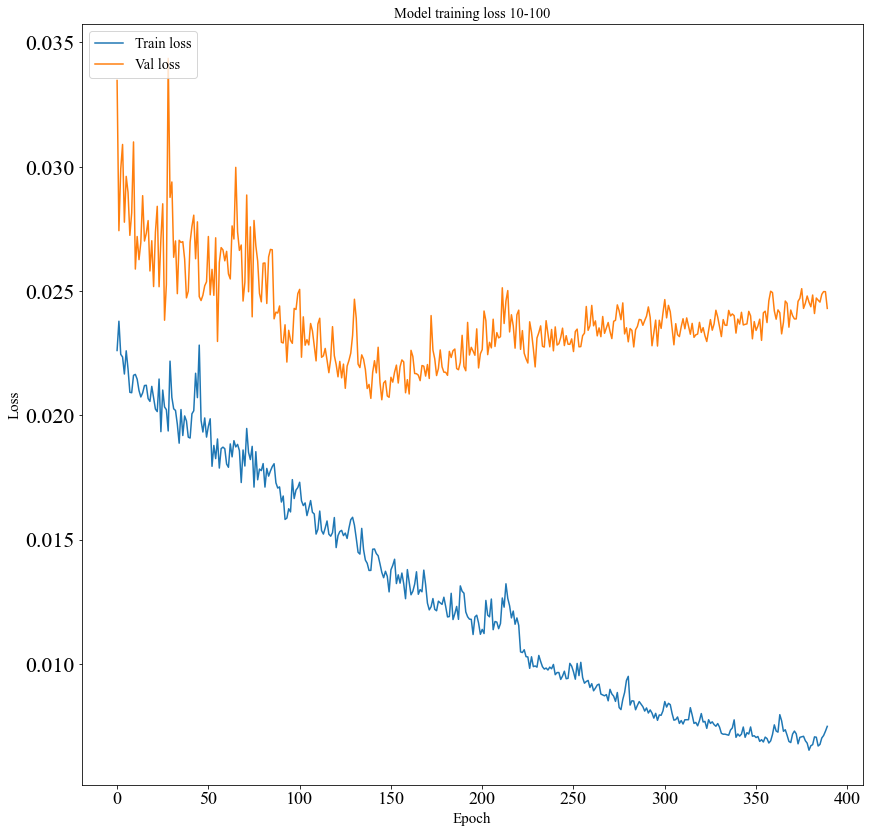

In [67]:
plt.plot(historyUrban.history['loss'][10:])
plt.plot(historyUrban.history['val_loss'][10:])

plt.title('Model training loss 10-100')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], loc='upper left')
plt.show()

In [50]:
### FIT FORECASTER ###
# plt.plot(historyUrban.history['loss'][10:])

"""# UNSEEN DATA PREDICTION"""

### FUNCTION FOR STOCHASTIC DROPOUT FOR UNSEEN COUNTY ###


def test_other_drop1(typ, enc, NN, hurricane):
    if typ == 'Urban':
        X = X_test_c
        F = f_test_c
        y = y_test_c
        if hurricane == False:
            F = f_test_c_noHurricane

    elif typ == 'Rural':
        X = X_test_o
        F = f_test_o
        y = y_test_o
        if hurricane == False:
            F = f_test_o_noHurricane
    
    enc_pred = enc.predict(X)
    enc_pred = np.concatenate([enc_pred, F], axis=2)
    trans_pred = scaler1Urban.transform(
        enc_pred.reshape(-1, enc_pred.shape[-1])).reshape(-1, sequence_length, enc_pred.shape[-1])
    NN_pred = NN.predict(trans_pred)

    return NN_pred, y


testCounties1 = ['Lee', 'Collier', 'Sarasota', 'Orange', 'Palm Beach']
testCounties1 = ['Collier']

In [32]:
# from sklearn.utils import check_arrays


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
          'axes.labelsize': '15',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': '18',
          'ytick.labelsize': '22',
          'font.family': 'Times new roman'}
pylab.rcParams.update(params)



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

7/7 [==============================] - 0s 24ms/step


  1%|▊                                                                                 | 1/100 [00:00<00:54,  1.81it/s]

7/7 [==============================] - 0s 20ms/step


  2%|█▋                                                                                | 2/100 [00:01<00:51,  1.91it/s]

7/7 [==============================] - 0s 24ms/step


  3%|██▍                                                                               | 3/100 [00:01<00:50,  1.92it/s]

7/7 [==============================] - 0s 22ms/step


  4%|███▎                                                                              | 4/100 [00:02<00:50,  1.90it/s]

7/7 [==============================] - 0s 22ms/step


  5%|████                                                                              | 5/100 [00:02<00:49,  1.93it/s]

7/7 [==============================] - 0s 24ms/step


  6%|████▉                                                                             | 6/100 [00:03<00:48,  1.92it/s]

7/7 [==============================] - 0s 23ms/step


  7%|█████▋                                                                            | 7/100 [00:03<00:48,  1.92it/s]

7/7 [==============================] - 0s 24ms/step


  8%|██████▌                                                                           | 8/100 [00:04<00:48,  1.90it/s]

7/7 [==============================] - 0s 26ms/step


  9%|███████▍                                                                          | 9/100 [00:04<00:47,  1.90it/s]

7/7 [==============================] - 0s 25ms/step


 10%|████████                                                                         | 10/100 [00:05<00:47,  1.89it/s]

7/7 [==============================] - 0s 26ms/step


 11%|████████▉                                                                        | 11/100 [00:05<00:46,  1.90it/s]

7/7 [==============================] - 0s 25ms/step


 12%|█████████▋                                                                       | 12/100 [00:06<00:46,  1.89it/s]

7/7 [==============================] - 0s 24ms/step


 13%|██████████▌                                                                      | 13/100 [00:06<00:46,  1.89it/s]

7/7 [==============================] - 0s 22ms/step


 14%|███████████▎                                                                     | 14/100 [00:07<00:45,  1.89it/s]

7/7 [==============================] - 0s 25ms/step


 15%|████████████▏                                                                    | 15/100 [00:07<00:44,  1.90it/s]

7/7 [==============================] - 0s 24ms/step


 16%|████████████▉                                                                    | 16/100 [00:08<00:44,  1.90it/s]

7/7 [==============================] - 0s 22ms/step


 17%|█████████████▊                                                                   | 17/100 [00:08<00:43,  1.90it/s]

7/7 [==============================] - 0s 23ms/step


 18%|██████████████▌                                                                  | 18/100 [00:09<00:43,  1.89it/s]

7/7 [==============================] - 0s 26ms/step


 19%|███████████████▍                                                                 | 19/100 [00:10<00:42,  1.89it/s]

7/7 [==============================] - 0s 25ms/step


 20%|████████████████▏                                                                | 20/100 [00:10<00:42,  1.89it/s]

7/7 [==============================] - 0s 25ms/step


 21%|█████████████████                                                                | 21/100 [00:11<00:41,  1.88it/s]

7/7 [==============================] - 0s 25ms/step


 22%|█████████████████▊                                                               | 22/100 [00:11<00:41,  1.90it/s]

7/7 [==============================] - 0s 25ms/step


 23%|██████████████████▋                                                              | 23/100 [00:12<00:40,  1.92it/s]

7/7 [==============================] - 0s 25ms/step


 24%|███████████████████▍                                                             | 24/100 [00:12<00:40,  1.87it/s]

7/7 [==============================] - 0s 26ms/step


 25%|████████████████████▎                                                            | 25/100 [00:13<00:40,  1.86it/s]

7/7 [==============================] - 0s 26ms/step


 26%|█████████████████████                                                            | 26/100 [00:13<00:39,  1.86it/s]

7/7 [==============================] - 0s 26ms/step


 27%|█████████████████████▊                                                           | 27/100 [00:14<00:39,  1.87it/s]

7/7 [==============================] - 0s 24ms/step


 28%|██████████████████████▋                                                          | 28/100 [00:14<00:38,  1.87it/s]

7/7 [==============================] - 0s 25ms/step


 29%|███████████████████████▍                                                         | 29/100 [00:15<00:38,  1.82it/s]

7/7 [==============================] - 0s 25ms/step


 30%|████████████████████████▎                                                        | 30/100 [00:15<00:38,  1.82it/s]

7/7 [==============================] - 0s 23ms/step


 31%|█████████████████████████                                                        | 31/100 [00:16<00:37,  1.85it/s]

7/7 [==============================] - 0s 24ms/step


 32%|█████████████████████████▉                                                       | 32/100 [00:16<00:36,  1.86it/s]

7/7 [==============================] - 0s 24ms/step


 33%|██████████████████████████▋                                                      | 33/100 [00:17<00:35,  1.87it/s]

7/7 [==============================] - 0s 23ms/step


 34%|███████████████████████████▌                                                     | 34/100 [00:18<00:34,  1.89it/s]

7/7 [==============================] - 0s 25ms/step


 35%|████████████████████████████▎                                                    | 35/100 [00:18<00:34,  1.90it/s]

7/7 [==============================] - 0s 22ms/step


 36%|█████████████████████████████▏                                                   | 36/100 [00:19<00:33,  1.92it/s]

7/7 [==============================] - 0s 23ms/step


 37%|█████████████████████████████▉                                                   | 37/100 [00:19<00:32,  1.92it/s]

7/7 [==============================] - 0s 24ms/step


 38%|██████████████████████████████▊                                                  | 38/100 [00:20<00:32,  1.92it/s]

7/7 [==============================] - 0s 24ms/step


 39%|███████████████████████████████▌                                                 | 39/100 [00:20<00:31,  1.92it/s]

7/7 [==============================] - 0s 25ms/step


 40%|████████████████████████████████▍                                                | 40/100 [00:21<00:31,  1.93it/s]

7/7 [==============================] - 0s 24ms/step


 41%|█████████████████████████████████▏                                               | 41/100 [00:21<00:30,  1.92it/s]

7/7 [==============================] - 0s 23ms/step


 42%|██████████████████████████████████                                               | 42/100 [00:22<00:30,  1.93it/s]

7/7 [==============================] - 0s 24ms/step


 43%|██████████████████████████████████▊                                              | 43/100 [00:22<00:29,  1.92it/s]

7/7 [==============================] - 0s 24ms/step


 44%|███████████████████████████████████▋                                             | 44/100 [00:23<00:29,  1.92it/s]

7/7 [==============================] - 0s 25ms/step


 45%|████████████████████████████████████▍                                            | 45/100 [00:23<00:28,  1.91it/s]

7/7 [==============================] - 0s 24ms/step


 46%|█████████████████████████████████████▎                                           | 46/100 [00:24<00:28,  1.91it/s]

7/7 [==============================] - 0s 25ms/step


 47%|██████████████████████████████████████                                           | 47/100 [00:24<00:27,  1.91it/s]

7/7 [==============================] - 0s 25ms/step


 48%|██████████████████████████████████████▉                                          | 48/100 [00:25<00:27,  1.90it/s]

7/7 [==============================] - 0s 23ms/step


 49%|███████████████████████████████████████▋                                         | 49/100 [00:25<00:26,  1.90it/s]

7/7 [==============================] - 0s 25ms/step


 50%|████████████████████████████████████████▌                                        | 50/100 [00:26<00:26,  1.91it/s]

7/7 [==============================] - 0s 25ms/step


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:26<00:25,  1.92it/s]

7/7 [==============================] - 0s 24ms/step


 52%|██████████████████████████████████████████                                       | 52/100 [00:27<00:25,  1.91it/s]

7/7 [==============================] - 0s 25ms/step


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:27<00:24,  1.92it/s]

7/7 [==============================] - 0s 25ms/step


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:28<00:23,  1.92it/s]

7/7 [==============================] - 0s 23ms/step


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:28<00:23,  1.91it/s]

7/7 [==============================] - 0s 24ms/step


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:29<00:23,  1.91it/s]

7/7 [==============================] - 0s 24ms/step


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:30<00:22,  1.91it/s]

7/7 [==============================] - 0s 23ms/step


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:30<00:21,  1.91it/s]

7/7 [==============================] - 0s 22ms/step


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:31<00:21,  1.94it/s]

7/7 [==============================] - 0s 23ms/step


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:31<00:20,  1.94it/s]

7/7 [==============================] - 0s 24ms/step


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:32<00:20,  1.92it/s]

7/7 [==============================] - 0s 23ms/step


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:32<00:19,  1.92it/s]

7/7 [==============================] - 0s 23ms/step


 63%|███████████████████████████████████████████████████                              | 63/100 [00:33<00:19,  1.91it/s]

7/7 [==============================] - 0s 22ms/step


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:33<00:18,  1.91it/s]

7/7 [==============================] - 0s 21ms/step


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:34<00:18,  1.90it/s]

7/7 [==============================] - 0s 21ms/step


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:34<00:17,  1.92it/s]

7/7 [==============================] - 0s 25ms/step


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:35<00:17,  1.91it/s]

7/7 [==============================] - 0s 23ms/step


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:35<00:16,  1.91it/s]

7/7 [==============================] - 0s 25ms/step


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:36<00:16,  1.92it/s]

7/7 [==============================] - 0s 22ms/step


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:36<00:15,  1.91it/s]

7/7 [==============================] - 0s 24ms/step


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:37<00:15,  1.91it/s]

7/7 [==============================] - 0s 24ms/step


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:37<00:14,  1.91it/s]

7/7 [==============================] - 0s 23ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:38<00:14,  1.85it/s]

7/7 [==============================] - 0s 26ms/step


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:38<00:13,  1.88it/s]

7/7 [==============================] - 0s 24ms/step


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:39<00:13,  1.88it/s]

7/7 [==============================] - 0s 23ms/step


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:40<00:12,  1.88it/s]

7/7 [==============================] - 0s 23ms/step


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:40<00:12,  1.91it/s]

7/7 [==============================] - 0s 25ms/step


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:41<00:11,  1.85it/s]

7/7 [==============================] - 0s 23ms/step


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:41<00:11,  1.82it/s]

7/7 [==============================] - 0s 23ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:42<00:11,  1.81it/s]

7/7 [==============================] - 0s 22ms/step


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:42<00:10,  1.85it/s]

7/7 [==============================] - 0s 25ms/step


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:43<00:09,  1.87it/s]

7/7 [==============================] - 0s 23ms/step


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:43<00:09,  1.86it/s]

7/7 [==============================] - 0s 22ms/step


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:44<00:08,  1.87it/s]

7/7 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:44<00:07,  1.89it/s]

7/7 [==============================] - 0s 23ms/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:45<00:07,  1.88it/s]

7/7 [==============================] - 0s 23ms/step


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:45<00:06,  1.88it/s]

7/7 [==============================] - 0s 22ms/step


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:46<00:06,  1.91it/s]

7/7 [==============================] - 0s 20ms/step


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:46<00:05,  1.96it/s]

7/7 [==============================] - 0s 20ms/step


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:47<00:04,  2.05it/s]

7/7 [==============================] - 0s 22ms/step


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:47<00:04,  2.13it/s]

7/7 [==============================] - 0s 22ms/step


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:48<00:03,  2.13it/s]

7/7 [==============================] - 0s 20ms/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:48<00:03,  2.17it/s]

7/7 [==============================] - 0s 24ms/step


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:49<00:02,  2.16it/s]

7/7 [==============================] - 0s 24ms/step


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:49<00:02,  2.11it/s]

7/7 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:50<00:01,  2.04it/s]

7/7 [==============================] - 0s 24ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:50<00:01,  2.00it/s]

7/7 [==============================] - 0s 24ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:51<00:01,  2.00it/s]

7/7 [==============================] - 0s 25ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:51<00:00,  1.98it/s]

7/7 [==============================] - 0s 24ms/step


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Collier	Urban  	 MAE 0.01938206621782188 	 0.0008286712018797649
Collier	Urban  	 RMSE 0.026095330607585433 	 0.001287412353549297
Collier	Urban  	 MAPE 20.857519006142326 	 0.9467264446437723
7/7 [==============================] - 0s 25ms/step


  1%|▊                                                                                 | 1/100 [00:00<00:50,  1.95it/s]

7/7 [==============================] - 0s 24ms/step


  2%|█▋                                                                                | 2/100 [00:01<00:51,  1.92it/s]

7/7 [==============================] - 0s 24ms/step


  3%|██▍                                                                               | 3/100 [00:01<00:50,  1.94it/s]

7/7 [==============================] - 0s 24ms/step


  4%|███▎                                                                              | 4/100 [00:02<00:50,  1.91it/s]

7/7 [==============================] - 0s 24ms/step


  5%|████                                                                              | 5/100 [00:02<00:49,  1.91it/s]

7/7 [==============================] - 0s 23ms/step


  6%|████▉                                                                             | 6/100 [00:03<00:49,  1.91it/s]

7/7 [==============================] - 0s 25ms/step


  7%|█████▋                                                                            | 7/100 [00:03<00:48,  1.91it/s]

7/7 [==============================] - 0s 24ms/step


  8%|██████▌                                                                           | 8/100 [00:04<00:48,  1.90it/s]

7/7 [==============================] - 0s 24ms/step


  9%|███████▍                                                                          | 9/100 [00:04<00:47,  1.92it/s]

7/7 [==============================] - 0s 24ms/step


 10%|████████                                                                         | 10/100 [00:05<00:46,  1.93it/s]

7/7 [==============================] - 0s 24ms/step


 11%|████████▉                                                                        | 11/100 [00:05<00:45,  1.95it/s]

7/7 [==============================] - 0s 24ms/step


 12%|█████████▋                                                                       | 12/100 [00:06<00:45,  1.93it/s]

7/7 [==============================] - 0s 23ms/step


 13%|██████████▌                                                                      | 13/100 [00:06<00:45,  1.92it/s]

7/7 [==============================] - 0s 24ms/step


 14%|███████████▎                                                                     | 14/100 [00:07<00:44,  1.92it/s]

7/7 [==============================] - 0s 23ms/step


 15%|████████████▏                                                                    | 15/100 [00:07<00:43,  1.93it/s]

7/7 [==============================] - 0s 24ms/step


 16%|████████████▉                                                                    | 16/100 [00:08<00:43,  1.91it/s]

7/7 [==============================] - 0s 21ms/step


 17%|█████████████▊                                                                   | 17/100 [00:08<00:42,  1.96it/s]

7/7 [==============================] - 0s 25ms/step


 18%|██████████████▌                                                                  | 18/100 [00:09<00:41,  1.96it/s]

7/7 [==============================] - 0s 26ms/step


 19%|███████████████▍                                                                 | 19/100 [00:09<00:41,  1.97it/s]

7/7 [==============================] - 0s 25ms/step


 20%|████████████████▏                                                                | 20/100 [00:10<00:41,  1.93it/s]

7/7 [==============================] - 0s 25ms/step


 21%|█████████████████                                                                | 21/100 [00:10<00:40,  1.93it/s]

7/7 [==============================] - 0s 25ms/step


 22%|█████████████████▊                                                               | 22/100 [00:11<00:40,  1.91it/s]

7/7 [==============================] - 0s 23ms/step


 23%|██████████████████▋                                                              | 23/100 [00:11<00:40,  1.92it/s]

7/7 [==============================] - 0s 26ms/step


 24%|███████████████████▍                                                             | 24/100 [00:12<00:40,  1.89it/s]

7/7 [==============================] - 0s 23ms/step


 25%|████████████████████▎                                                            | 25/100 [00:13<00:39,  1.89it/s]

7/7 [==============================] - 0s 23ms/step


 26%|█████████████████████                                                            | 26/100 [00:13<00:38,  1.90it/s]

7/7 [==============================] - 0s 25ms/step


 27%|█████████████████████▊                                                           | 27/100 [00:14<00:38,  1.87it/s]

7/7 [==============================] - 0s 25ms/step


 28%|██████████████████████▋                                                          | 28/100 [00:14<00:38,  1.87it/s]

7/7 [==============================] - 0s 25ms/step


 29%|███████████████████████▍                                                         | 29/100 [00:15<00:38,  1.84it/s]

7/7 [==============================] - 0s 23ms/step


 30%|████████████████████████▎                                                        | 30/100 [00:15<00:37,  1.86it/s]

7/7 [==============================] - 0s 25ms/step


 31%|█████████████████████████                                                        | 31/100 [00:16<00:37,  1.85it/s]

7/7 [==============================] - 0s 23ms/step


 32%|█████████████████████████▉                                                       | 32/100 [00:16<00:36,  1.87it/s]

7/7 [==============================] - 0s 23ms/step


 33%|██████████████████████████▋                                                      | 33/100 [00:17<00:35,  1.87it/s]

7/7 [==============================] - 0s 25ms/step


 34%|███████████████████████████▌                                                     | 34/100 [00:17<00:34,  1.89it/s]

7/7 [==============================] - 0s 23ms/step


 35%|████████████████████████████▎                                                    | 35/100 [00:18<00:34,  1.90it/s]

7/7 [==============================] - 0s 23ms/step


 36%|█████████████████████████████▏                                                   | 36/100 [00:18<00:33,  1.90it/s]

7/7 [==============================] - 0s 23ms/step


 37%|█████████████████████████████▉                                                   | 37/100 [00:19<00:33,  1.91it/s]

7/7 [==============================] - 0s 23ms/step


 38%|██████████████████████████████▊                                                  | 38/100 [00:19<00:32,  1.92it/s]

7/7 [==============================] - 0s 25ms/step


 39%|███████████████████████████████▌                                                 | 39/100 [00:20<00:31,  1.92it/s]

7/7 [==============================] - 0s 26ms/step


 40%|████████████████████████████████▍                                                | 40/100 [00:20<00:31,  1.93it/s]

7/7 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████▏                                               | 41/100 [00:21<00:30,  1.94it/s]

7/7 [==============================] - 0s 25ms/step


 42%|██████████████████████████████████                                               | 42/100 [00:21<00:30,  1.92it/s]

7/7 [==============================] - 0s 24ms/step


 43%|██████████████████████████████████▊                                              | 43/100 [00:22<00:29,  1.93it/s]

7/7 [==============================] - 0s 23ms/step


 44%|███████████████████████████████████▋                                             | 44/100 [00:23<00:29,  1.92it/s]

7/7 [==============================] - 0s 24ms/step


 45%|████████████████████████████████████▍                                            | 45/100 [00:23<00:28,  1.92it/s]

7/7 [==============================] - 0s 25ms/step


 46%|█████████████████████████████████████▎                                           | 46/100 [00:24<00:28,  1.92it/s]

7/7 [==============================] - 0s 23ms/step


 47%|██████████████████████████████████████                                           | 47/100 [00:24<00:27,  1.93it/s]

7/7 [==============================] - 0s 23ms/step


 48%|██████████████████████████████████████▉                                          | 48/100 [00:25<00:27,  1.92it/s]

7/7 [==============================] - 0s 25ms/step


 49%|███████████████████████████████████████▋                                         | 49/100 [00:25<00:26,  1.92it/s]

7/7 [==============================] - 0s 25ms/step


 50%|████████████████████████████████████████▌                                        | 50/100 [00:26<00:26,  1.88it/s]

7/7 [==============================] - 0s 26ms/step


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:26<00:26,  1.84it/s]

7/7 [==============================] - 0s 26ms/step


 52%|██████████████████████████████████████████                                       | 52/100 [00:27<00:26,  1.82it/s]

7/7 [==============================] - 0s 25ms/step


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:27<00:25,  1.86it/s]

7/7 [==============================] - 0s 20ms/step


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:28<00:24,  1.86it/s]

7/7 [==============================] - 0s 26ms/step


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:28<00:24,  1.86it/s]

7/7 [==============================] - 0s 25ms/step


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:29<00:23,  1.85it/s]

7/7 [==============================] - 0s 25ms/step


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:29<00:22,  1.88it/s]

7/7 [==============================] - 0s 23ms/step


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:30<00:22,  1.89it/s]

7/7 [==============================] - 0s 25ms/step


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:31<00:21,  1.89it/s]

7/7 [==============================] - 0s 25ms/step


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:31<00:21,  1.88it/s]

7/7 [==============================] - 0s 25ms/step


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:32<00:20,  1.89it/s]

7/7 [==============================] - 0s 26ms/step


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:32<00:19,  1.91it/s]

7/7 [==============================] - 0s 23ms/step


 63%|███████████████████████████████████████████████████                              | 63/100 [00:33<00:19,  1.91it/s]

7/7 [==============================] - 0s 26ms/step


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:33<00:18,  1.91it/s]

7/7 [==============================] - 0s 23ms/step


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:34<00:18,  1.91it/s]

7/7 [==============================] - 0s 23ms/step


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:34<00:17,  1.92it/s]

7/7 [==============================] - 0s 25ms/step


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:35<00:17,  1.94it/s]

7/7 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:35<00:16,  1.93it/s]

7/7 [==============================] - 0s 23ms/step


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:36<00:16,  1.93it/s]

7/7 [==============================] - 0s 25ms/step


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:36<00:15,  1.92it/s]

7/7 [==============================] - 0s 24ms/step


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:37<00:15,  1.93it/s]

7/7 [==============================] - 0s 24ms/step


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:37<00:14,  1.91it/s]

7/7 [==============================] - 0s 25ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:38<00:14,  1.91it/s]

7/7 [==============================] - 0s 24ms/step


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:38<00:13,  1.92it/s]

7/7 [==============================] - 0s 25ms/step


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:39<00:12,  1.92it/s]

7/7 [==============================] - 0s 23ms/step


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:39<00:12,  1.93it/s]

7/7 [==============================] - 0s 25ms/step


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:40<00:11,  1.93it/s]

7/7 [==============================] - 0s 24ms/step


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:40<00:11,  1.91it/s]

7/7 [==============================] - 0s 23ms/step


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:41<00:10,  1.93it/s]

7/7 [==============================] - 0s 24ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:41<00:10,  1.91it/s]

7/7 [==============================] - 0s 23ms/step


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:42<00:09,  1.90it/s]

7/7 [==============================] - 0s 22ms/step


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:43<00:09,  1.92it/s]

7/7 [==============================] - 0s 24ms/step


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:43<00:08,  1.92it/s]

7/7 [==============================] - 0s 22ms/step


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:44<00:08,  1.94it/s]

7/7 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:44<00:07,  1.92it/s]

7/7 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:45<00:07,  1.93it/s]

7/7 [==============================] - 0s 23ms/step


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:45<00:06,  1.93it/s]

7/7 [==============================] - 0s 24ms/step


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:46<00:06,  1.93it/s]

7/7 [==============================] - 0s 22ms/step


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:46<00:05,  1.93it/s]

7/7 [==============================] - 0s 23ms/step


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:47<00:05,  1.94it/s]

7/7 [==============================] - 0s 22ms/step


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:47<00:04,  1.93it/s]

7/7 [==============================] - 0s 23ms/step


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:48<00:04,  1.92it/s]

7/7 [==============================] - 0s 23ms/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:48<00:03,  1.99it/s]

7/7 [==============================] - 0s 23ms/step


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:49<00:03,  1.97it/s]

7/7 [==============================] - 0s 24ms/step


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:49<00:02,  1.96it/s]

7/7 [==============================] - 0s 23ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:50<00:02,  1.94it/s]

7/7 [==============================] - 0s 24ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:50<00:01,  1.93it/s]

7/7 [==============================] - 0s 24ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:51<00:01,  1.93it/s]

7/7 [==============================] - 0s 25ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:51<00:00,  1.94it/s]

7/7 [==============================] - 0s 23ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.91it/s]

Collier	Urban	Urban no hurricane 	 0.01896351190683568 	 0.0008354040802261581


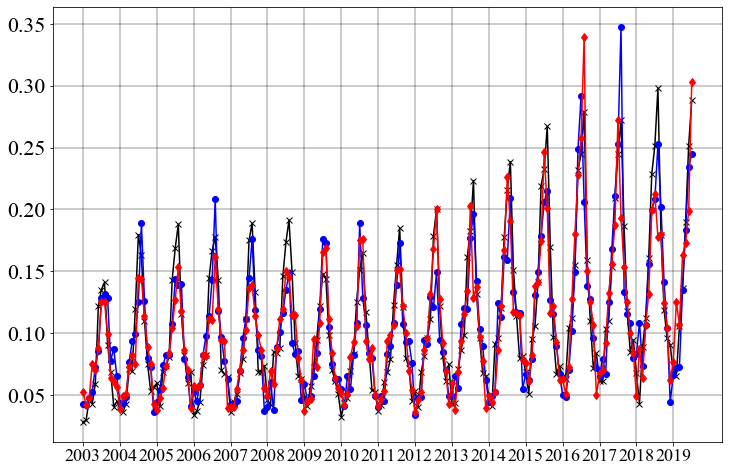

In [53]:
lst = []
lst
lstBoxPlot = []


for j in testCounties1:
    county_name = j
    b = df[(df["region"] == j)]
    county_type = b['type'].unique()[0]
    if str(b['type'].values[0]) == 'nan':
        print('Not defined county type!')
        continue
    X_test_c, X_test_o = [], []
    y_test_c, y_test_o = [], []
    f_test_c, f_test_o = [], []
    f_test_c_noHurricane, f_test_o_noHurricane = [], []

    for county in df["region"].unique():
        for sequence in gen_sequence(df[(df["region"] == county) & (df["type"] == "Urban")],
                                     sequence_length, ['observed']):
            if county == j:
                X_test_c.append(sequence)

        for sequence in gen_sequence(df[(df["region"] == county) & (df["type"] == "Rural")],
                                     sequence_length, ['observed']):
            if county == j:
                X_test_o.append(sequence)
    X_test_c, X_test_o = np.asarray(X_test_c), np.asarray(X_test_o)
    ####

    for county in df["region"].unique():
        for sequence in gen_labels(df[(df["region"] == county) & (df["type"] == "Urban")],
                                   sequence_length, ['observed']):
            if county == j:
                y_test_c.append(sequence)
        for sequence in gen_labels(df[(df["region"] == county) & (df["type"] == "Rural")],
                                   sequence_length, ['observed']):
            if county == j:
                y_test_o.append(sequence)
    y_test_c, y_test_o = np.asarray(y_test_c), np.asarray(y_test_o)
    ### CREATE TRAIN/TEST EXTERNAL FEATURES ###
    col = ['residual', "seasonal", 'trend', 'hurricane']
    for county in df["region"].unique():
        for sequence in gen_sequence(df[(df["region"] == county) & (df["type"] == "Urban")],
                                     sequence_length, col):
            if county == j:
                f_test_c.append(sequence)
        for sequence in gen_sequence(df[(df["region"] == county) & (df["type"] == "Rural")],
                                     sequence_length, col):
            if county == j:
                f_test_o.append(sequence)
    f_test_c, f_test_o = np.asarray(f_test_c), np.asarray(f_test_o)

    col = ['residual', "seasonal", 'trend', 'hurricane']
    dfnohurricane = df.copy()
    dfnohurricane['hurricane'] = 0
    for county in dfnohurricane["region"].unique():
        for sequence in gen_sequence(dfnohurricane[(dfnohurricane["region"] == county) & (dfnohurricane["type"] == "Urban")],
                                     sequence_length, col):
            if county == j:
                f_test_c_noHurricane.append(sequence)
        for sequence in gen_sequence(dfnohurricane[(dfnohurricane["region"] == county) & (dfnohurricane["type"] == "Rural")],
                                     sequence_length, col):
            if county == j:
                f_test_o_noHurricane.append(sequence)
    f_test_c_noHurricane, f_test_o_noHurricane = np.asarray(
        f_test_c_noHurricane), np.asarray(f_test_o_noHurricane)

    if county_type == "Urban":

        hurricane = True

        MAE, trueValuesList = [], []
        RMSE = []
        MAPE = []
        encUrban = encoderUrban
        NNUrban = model1Urban
        
        for i in tqdm.tqdm(range(0, 100)):

            predictedValues, trueValues = test_other_drop1(
                county_type, encUrban, NNUrban, hurricane)
            MAE.append(mean_absolute_error(predictedValues, trueValues))
            RMSE.append(np.sqrt(mean_squared_error(
                predictedValues, trueValues)))
            MAPE.append(mean_absolute_percentage_error(
                predictedValues, trueValues))

            trueValuesList.append(trueValues)
            a = 'a'+str(i)
            predictedValues1 = predictedValues.reshape(1, len(predictedValues))
        print(county_name+'\t'+'Urban ', '\t',
              'MAE', np.mean(MAE), '\t', np.std(MAE))
        print(county_name+'\t'+'Urban ', '\t', 'RMSE',
              np.mean(RMSE), '\t', np.std(RMSE))
        print(county_name+'\t'+'Urban ', '\t', 'MAPE',
              np.mean(MAPE), '\t', np.std(MAPE))

        hurricane = False

        MAENoHurricane, trueValuesList = [], []
        #encUrban = K.function([encoderUrban.layers[0].input], [
                              #encoderUrban.layers[-1].output])
        #NNUrban = K.function([model1Urban.layers[0].input], [
                             #model1Urban.layers[-1].output])

        for i in tqdm.tqdm(range(0, 100)):
            predictedValuesNoHurricane, trueValues = test_other_drop1(
                county_type, encUrban, NNUrban, hurricane)
            MAENoHurricane.append(mean_absolute_error(
                predictedValuesNoHurricane, trueValues))
            trueValuesList.append(trueValues)

        print(county_name+'\t'+county_type+'\t'+'Urban no hurricane',
              '\t', np.mean(MAENoHurricane), '\t', np.std(MAENoHurricane))

    ### COMPUTE STOCHASTIC DROPOUT FOR UNSEEN COUNTY ###
    if county_type == 'Rural':

        hurricane = True

        MAE, trueValuesList = [], []
        encRural = encoderRural
        NNRural = model1Rural
        
        for i in tqdm.tqdm(range(0, 100)):
            predictedValues, trueValues = test_other_drop1(
                county_type, encRural, NNRural, hurricane)
            MAE.append(mean_absolute_error(predictedValues, trueValues))
            trueValuesList.append(trueValues)

        print(county_name+'\t'+county_type+'\t'+"Rural",
              '\t', np.mean(MAE), '\t', np.std(MAE))

        hurricane = False
        MAENoHurricane, trueValuesList = [], []
        encRural = encoderRural
        NNRural = model1Rural

        for i in tqdm.tqdm(range(0, 100)):
            predictedValuesNoHurricane, trueValues = test_other_drop1(
                county_type, encRural, NNRural, hurricane)
            MAENoHurricane.append(mean_absolute_error(
                predictedValuesNoHurricane, trueValues))
            trueValuesList.append(trueValues)

        print(county_name+'\t'+county_type+'\t'+'Rural no hurricane',
              '\t', np.mean(MAENoHurricane), '\t', np.std(MAENoHurricane))
        
   

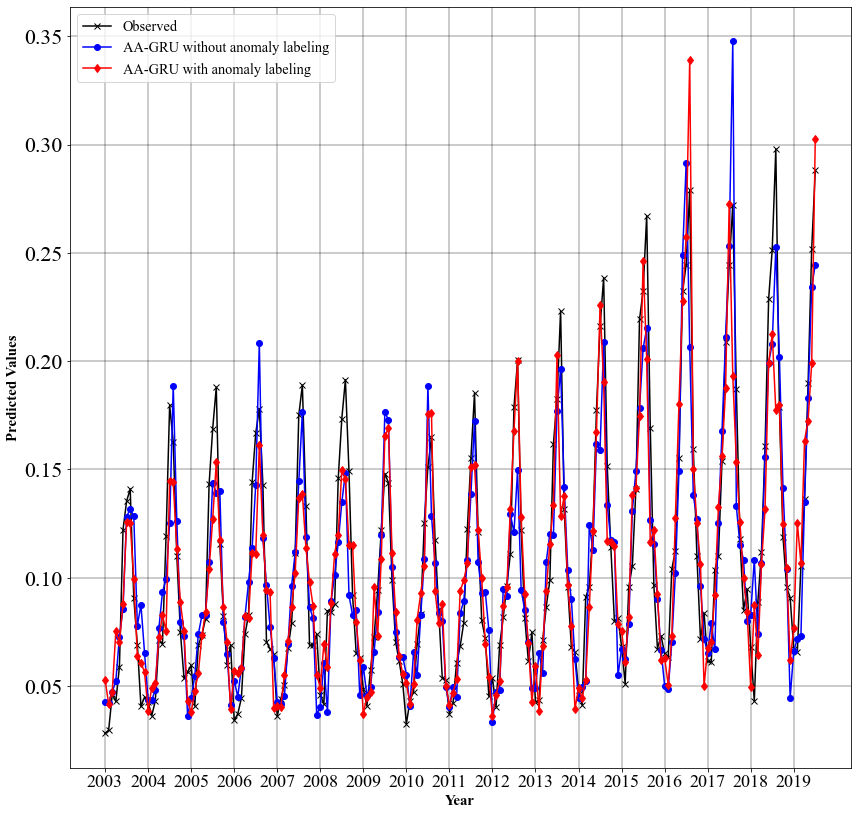

In [59]:
plt.rcParams['figure.figsize'] = 14, 14
lst.append([category, dropOut, county_type, county_name, np.mean(MAENoHurricane), np.std(MAENoHurricane), np.mean(MAE), np.std(MAE)
                ])

f, ax = plt.subplots()
ax.plot(np.mean(np.hstack(trueValuesList).T, axis=0),
            color='black', label='Observed', marker='x')
label1 = "AA-GRU with anomaly labeling"
label2 = "AA-GRU without anomaly labeling"

ax.plot(predictedValuesNoHurricane, color='blue', label=label2, marker='o')
ax.plot(predictedValues, color='red', label=label1, marker='d')

# ax.plot(b["hurricane"].iloc[10:].values,label = 'Anomaly Label (Hurricane 1-5)',color='orange')
hur = b["hurricane"].iloc[12:].values
trueVals = np.mean(np.hstack(trueValuesList).T, axis=0)

ax.set_xticklabels(df['Date'].values[0:len(y_test_o[0:splitTest])])
ax.set_xticks(customXLabel)
ax.set_xticklabels(df['year'].unique()[1:])
ax.set_xticklabels(df['Date'].values[0:len(y_test_o[0:splitTest])])
ax.set_xticks(customXLabel)
ax.set_xticklabels(df['year'].unique()[1:])
ax.set_xticklabels(df['year'].unique()[1:])

plt.xlabel('Year',fontweight ='bold', fontsize = 15)
plt.ylabel('Predicted Values', fontweight ='bold', fontsize = 15)
plt.legend(loc='upper left')
plt.grid(color='k', linestyle='-', linewidth=0.4)
plt.savefig('.//output//'+category+"_"+county_type+"_" +
                county_name+'DropOut_'+str(dropOut)+'.png')

plt.show()
x = 0
cols = ['Category', 'DropOut', 'type', 'countyName',
        'MAEnoHur', 'STDnoHur', 'MAE', 'STD']
excelResults = pd.DataFrame(lst, columns=cols)
districols = ['region', 'type', 'hurricane', 'Date', 'observed', 'residual',
              'true', 'predicted no hurricane', 'changes from ori', 'predicted hurricane', 'predicted changes from ori', 'changes hur to no hur', ]

excelDistri = pd.DataFrame(lstBoxPlot, columns=districols)


   

### Contribution in project

- Changing the hyperparameters to check how training loss and val_loss changes

- **dropOut** = 0.2

- **epochs** = 200

- **lstmcell1Urban** = 128

- **lstmcell2Urban** = 128

- **dense1Urban** = 32

- **lstmcell1Rural** = 64

- **lstmcell2Rural** = 16

- **dense1Rural** = 16


In [60]:
"""# GRU after AutoEncoder Urban & Rural"""

os.environ['PYTHONHASHSEED'] = str(47)
np.random.seed(47)
random.seed(47)

dropOut = 0.2
epochs = 200
lstmcell1Urban = 128
lstmcell2Urban = 128
dense1Urban = 32

lstmcell1Rural = 64
lstmcell2Rural = 16
dense1Rural = 16


encoderUrban = Model(inputsUrbanAE, encodedUrbanAE)
XXUrban = encoderUrban.predict(XUrban)
XXFUrban = np.concatenate([XXUrban, FUrban], axis=2)
XXFUrban.shape
X_train1Urban, X_test1Urban = XXFUrban[:len(
    X_train_c)], XXFUrban[len(X_train_c):]
y_train1Urban, y_test1Urban = yUrban[:len(y_train_c)], yUrban[len(y_train_c):]
scaler1Urban = StandardScaler()
X_train1Urban = scaler1Urban.fit_transform(
    X_train1Urban.reshape(-1, XXFUrban.shape[-1])).reshape(-1, sequence_length, XXFUrban.shape[-1])
X_test1Urban = scaler1Urban.transform(
    X_test1Urban.reshape(-1, XXFUrban.shape[-1])).reshape(-1, sequence_length, XXFUrban.shape[-1])

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(),
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


193/193 [==============================] - 2s 7ms/step


In [61]:
### DEFINE FORECASTER ###
inputs1 = Input(shape=(X_train1Urban.shape[1], X_train1Urban.shape[2]))
lstm1 = GRU(lstmcell1Urban, return_sequences=True,
            dropout=dropOut)(inputs1, training=True)
lstm1 = GRU(lstmcell2Urban, return_sequences=False,
            dropout=dropOut)(lstm1, training=True)
dense1 = Dense(dense1Urban)(lstm1)
out1 = Dense(1)(dense1)

model1Urban = Model(inputs1, out1)
model1Urban.compile(loss=lossmetric, optimizer='adam', metrics=[lossmetric])


In [62]:
### FIT FORECASTER ###
historyUrban = model1Urban.fit(X_train1Urban[:4000], y_train1Urban[:4000], validation_data=(X_train1Urban[4000:], y_train1Urban[4000:]),
                               epochs=epochs, batch_size=128, verbose=2, shuffle=False)


Epoch 1/200
32/32 - 16s - loss: 0.1742 - mean_absolute_error: 0.1742 - val_loss: 0.0757 - val_mean_absolute_error: 0.0757 - 16s/epoch - 509ms/step
Epoch 2/200
32/32 - 3s - loss: 0.0450 - mean_absolute_error: 0.0450 - val_loss: 0.0402 - val_mean_absolute_error: 0.0402 - 3s/epoch - 97ms/step
Epoch 3/200
32/32 - 3s - loss: 0.0278 - mean_absolute_error: 0.0278 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335 - 3s/epoch - 100ms/step
Epoch 4/200
32/32 - 3s - loss: 0.0253 - mean_absolute_error: 0.0253 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317 - 3s/epoch - 100ms/step
Epoch 5/200
32/32 - 3s - loss: 0.0252 - mean_absolute_error: 0.0252 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312 - 3s/epoch - 99ms/step
Epoch 6/200
32/32 - 3s - loss: 0.0245 - mean_absolute_error: 0.0245 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283 - 3s/epoch - 100ms/step
Epoch 7/200
32/32 - 3s - loss: 0.0232 - mean_absolute_error: 0.0232 - val_loss: 0.0288 - val_mean_absolute_error: 0.0288 - 3s/epoc

Epoch 58/200
32/32 - 3s - loss: 0.0180 - mean_absolute_error: 0.0180 - val_loss: 0.0254 - val_mean_absolute_error: 0.0254 - 3s/epoch - 99ms/step
Epoch 59/200
32/32 - 3s - loss: 0.0177 - mean_absolute_error: 0.0177 - val_loss: 0.0248 - val_mean_absolute_error: 0.0248 - 3s/epoch - 100ms/step
Epoch 60/200
32/32 - 3s - loss: 0.0175 - mean_absolute_error: 0.0175 - val_loss: 0.0253 - val_mean_absolute_error: 0.0253 - 3s/epoch - 100ms/step
Epoch 61/200
32/32 - 3s - loss: 0.0177 - mean_absolute_error: 0.0177 - val_loss: 0.0269 - val_mean_absolute_error: 0.0269 - 3s/epoch - 99ms/step
Epoch 62/200
32/32 - 3s - loss: 0.0181 - mean_absolute_error: 0.0181 - val_loss: 0.0252 - val_mean_absolute_error: 0.0252 - 3s/epoch - 101ms/step
Epoch 63/200
32/32 - 3s - loss: 0.0177 - mean_absolute_error: 0.0177 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - 3s/epoch - 98ms/step
Epoch 64/200
32/32 - 3s - loss: 0.0169 - mean_absolute_error: 0.0169 - val_loss: 0.0253 - val_mean_absolute_error: 0.0253 - 3s/

Epoch 115/200
32/32 - 3s - loss: 0.0156 - mean_absolute_error: 0.0156 - val_loss: 0.0226 - val_mean_absolute_error: 0.0226 - 3s/epoch - 100ms/step
Epoch 116/200
32/32 - 3s - loss: 0.0160 - mean_absolute_error: 0.0160 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214 - 3s/epoch - 100ms/step
Epoch 117/200
32/32 - 3s - loss: 0.0151 - mean_absolute_error: 0.0151 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - 3s/epoch - 100ms/step
Epoch 118/200
32/32 - 3s - loss: 0.0159 - mean_absolute_error: 0.0159 - val_loss: 0.0226 - val_mean_absolute_error: 0.0226 - 3s/epoch - 99ms/step
Epoch 119/200
32/32 - 3s - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218 - 3s/epoch - 100ms/step
Epoch 120/200
32/32 - 3s - loss: 0.0156 - mean_absolute_error: 0.0156 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216 - 3s/epoch - 100ms/step
Epoch 121/200
32/32 - 3s - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0208 - val_mean_absolute_error: 0.0

Epoch 171/200
32/32 - 3s - loss: 0.0141 - mean_absolute_error: 0.0141 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203 - 3s/epoch - 99ms/step
Epoch 172/200
32/32 - 3s - loss: 0.0143 - mean_absolute_error: 0.0143 - val_loss: 0.0205 - val_mean_absolute_error: 0.0205 - 3s/epoch - 99ms/step
Epoch 173/200
32/32 - 3s - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202 - 3s/epoch - 99ms/step
Epoch 174/200
32/32 - 3s - loss: 0.0135 - mean_absolute_error: 0.0135 - val_loss: 0.0220 - val_mean_absolute_error: 0.0220 - 3s/epoch - 99ms/step
Epoch 175/200
32/32 - 3s - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203 - 3s/epoch - 98ms/step
Epoch 176/200
32/32 - 3s - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209 - 3s/epoch - 99ms/step
Epoch 177/200
32/32 - 3s - loss: 0.0131 - mean_absolute_error: 0.0131 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207 -

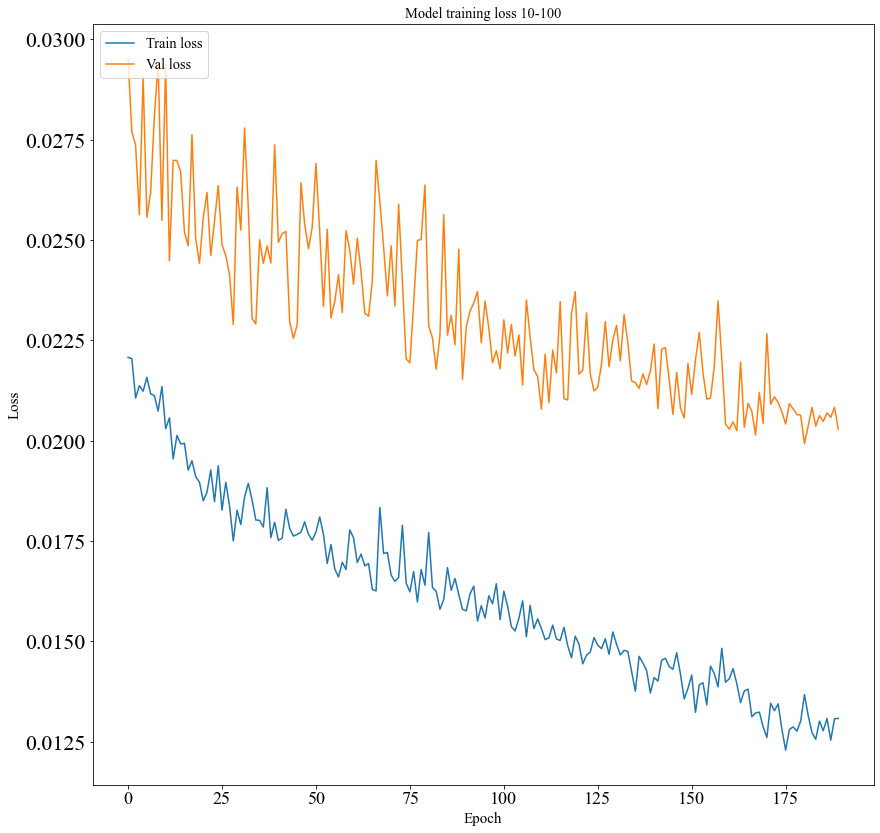

In [63]:
plt.plot(historyUrban.history['loss'][10:])
plt.plot(historyUrban.history['val_loss'][10:])

plt.title('Model training loss 10-100')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], loc='upper left')
plt.show()

- By looking at the above graph we can say that the change in hyperparameters has shown **continuous decrease** in validation loss, which can be seen decreasing and again increasing in the original research parameters.

- We can say that validation set accuracy can be improved by using these parameters.

